## Purpose: 
The purpose of this script is to plot the station density by income group as a background plot to explain the issue of geophysical data poverty. 

It includes some data-cleaning at the beginning of the script and then a bar plot. 

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr

from shapely.geometry import Point

# interactive plotting stuff 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

import seaborn as sns
#import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
#%config InlineBackend.figure_format = 'retina'

import rasterio
from rasterio.features import geometry_mask

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from datetime import datetime


In [78]:
# Set working directory
os.chdir("/dartfs-hpc/rc/lab/C/CMIG/moshea/Projects/DataPoverty")

# set export directory (where to export figures)
export_dir = "/dartfs-hpc/rc/lab/C/CMIG/moshea/Projects/BayesianStats_FinalProject/figures/"

## Data Sources
GHCN data 'ghcnd-inventory.txt' can be found here: https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt

Country Shapefiles can be found here: 'https://datacatalogfiles.worldbank.org/ddh-published/0038272/DR0046659/wb_countries_admin0_10m.zip?versionId=2023-11-27T15:22:14.9386101Z'

Country Area file can be found here:"https://api.worldbank.org/v2/en/indicator/AG.LND.TOTL.K2?downloadformat=csv"



## Cleaning

In [3]:
ghcn_dir = '/dartfs-hpc/rc/lab/C/CMIG/Data/Observations/GHCN'
inv = pd.read_fwf(os.path.join(ghcn_dir,'ghcnd-inventory.txt'),
                  colspecs=[(0,11),(12,20),(21,30),(31,35),(36,40),(41,45)],
                  header=None,
                  names=['ID','LAT','LON','VAR','START','END'])
inv['geometry'] = inv.apply(lambda row: Point(row['LON'],row['LAT']),axis=1)
inv = gpd.GeoDataFrame(inv)

In [4]:
#Download WB country shapefiles
#from io import BytesIO
#from urllib.request import urlopen
#from zipfile import ZipFile
#zipurl = 'https://datacatalogfiles.worldbank.org/ddh-published/0038272/DR0046659/wb_countries_admin0_10m.zip?versionId=2023-11-27T15:22:14.9386101Z'
#with urlopen(zipurl) as zipresp:
#    with ZipFile(BytesIO(zipresp.read())) as zfile:
#        zfile.extractall('../data/place_shapefiles')

In [9]:
countries = gpd.read_file('./OG_folders/data/place_shapefiles/WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')

Create DataFrame of the number of stations available in a given country per year

In [12]:
# Creating a list of years ranging from the minimum start year to the maximum end year
all_years = list(range(inv['START'].min(), inv['END'].max() + 1))

# Creating a DataFrame to store the results
result = pd.DataFrame(columns=['FIPS_10_'] + all_years)

# Grouping by country and calculating the number of stations per year
for country, group in inv.groupby('FIPS_10_'):
    yearly_counts = []
    for year in all_years:
        count = ((group['START'] <= year) & (group['END'] >= year)).sum()
        yearly_counts.append(count)
    result.loc[len(result)] = [country] + yearly_counts


In [68]:
stations_per_year = result.melt(id_vars='FIPS_10_', var_name='YEAR', value_name='number_of_stations')

In [15]:
stations2022 = countries_stations_inner[countries_stations_inner.YEAR==2022].copy(deep=True)

In [17]:
# Define conditions and values for the new column

quantile25 = stations2022['number_of_stations'].quantile(0.25)
quantile50 = stations2022['number_of_stations'].quantile(0.5)
quantile75 = stations2022['number_of_stations'].quantile(0.75)


conditions = [
    (stations2022['number_of_stations'] < quantile25),
    (stations2022['number_of_stations'] >= quantile25) & (stations2022['number_of_stations'] < quantile50),
    (stations2022['number_of_stations'] >= quantile50) & (stations2022['number_of_stations'] < quantile75),
    (stations2022['number_of_stations'] >= quantile75)
]
values = ['Low', 'Medium', 'Medium_High', 'High']

# Use numpy.select to assign values based on conditions
stations2022['Station_Category'] = np.select(conditions, values, default='Undefined')

#stations2022.head()

In [18]:
# Fixing the names of high medium low income so OECD and non-OECD are grouped together
conditions_income = [
    (stations2022['INCOME_GRP'] == "1. High income: OECD")|(stations2022['INCOME_GRP'] == "2. High income: nonOECD"),
    (stations2022['INCOME_GRP'] == "3. Upper middle income"),
    (stations2022['INCOME_GRP'] == "4. Lower middle income"),
    (stations2022['INCOME_GRP'] == "4. Low income")
]
values_income = ["High", "Upper-Middle", "Lower-Middle", "Low"]

# Use numpy.select to assign values based on conditions
stations2022['Income_Category'] = np.select(conditions_income, values_income, default='Undefined')

#stations2022.head()

In [20]:
mean_stations = stations2022.number_of_stations.mean()

stations2022['diff_from2022mean'] = stations2022['number_of_stations']-mean_stations
stations2022['log_GDP'] = np.log(stations2022['GDP_MD_EST'])

/dartfs-hpc/rc/home/5/f006z55/.conda/envs/mo12124/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
stations2022.POP_YEAR.unique() #[2017, 2013, 2016, 2014, 2015]
#stations2022.GDP_YEAR.unique() #[2016, 2015, 2014, 2013, 2010, 2012, 2003]
stations2022.head()
# the only overlapping year in the set
clean_stations2022 = stations2022[(stations2022['POP_YEAR']==2016)&(stations2022.GDP_YEAR==2016)].copy(deep=True)
clean_stations2022['gdppc'] = clean_stations2022['GDP_MD_EST']/clean_stations2022['POP_EST']

# Look at Station Density rather than pure number of stations

In [22]:
#Download Area df
#from io import BytesIO
#from urllib.request import urlopen
#from zipfile import ZipFile
#zipurl = "https://api.worldbank.org/v2/en/indicator/AG.LND.TOTL.K2?downloadformat=csv"
#with urlopen(zipurl) as zipresp:
#    with ZipFile(BytesIO(zipresp.read())) as zfile:
#        zfile.extractall('../data/')

In [26]:
country_area = pd.read_csv("./OG_folders/data/social_data/API_AG.LND.TOTL.K2_DS2_en_csv_v2_6298704.csv", header=2)
#country_area.head()

In [28]:
# fix country names to match so the datasets can merge
country_area.loc[country_area['Country Code'] == 'USA', ['Country Name']] = "United States of America"
country_area.loc[country_area['Country Code'] == 'GMB', ['Country Name']] = "The Gambia"
country_area.loc[country_area['Country Code'] == 'COG', ['Country Name']] = "Republic of the Congo"
country_area.loc[country_area['Country Code'] == 'VNM', ['Country Name']] = "Vietnam"
country_area.loc[country_area['Country Code'] == 'CIV', ['Country Name']] = "Ivory Coast"
country_area.loc[country_area['Country Code'] == 'SWZ', ['Country Name']] = "eSwatini"
country_area.loc[country_area['Country Code'] == 'BRN', ['Country Name']] = "Brunei"
country_area.loc[country_area['Country Code'] == 'IRN', ['Country Name']] = "Iran"
country_area.loc[country_area['Country Code'] == 'PRK', ['Country Name']] = "South Korea"
country_area.loc[country_area['Country Code'] == 'EGY', ['Country Name']] = "Egypt"
country_area.loc[country_area['Country Code'] == 'BHS', ['Country Name']] = "The Bahamas"


In [40]:
stations2021 = countries_stations_inner[countries_stations_inner.YEAR==2021].copy(deep=True)

country_area2021 = country_area[['Country Name', "Country Code", "2021"]].copy(deep=True)
country_area2021 = country_area2021.rename(columns={"2021": 'LandArea_sqkm', "Country Name":'NAME_EN'})
merge_area_stations = pd.merge(stations2021, country_area2021, on='NAME_EN', how="left")


In [43]:
#merge_area_stations_v2

In [41]:
merge_area_stations_v2 = merge_area_stations[merge_area_stations.GDP_MD_EST!=0].copy(deep=True)
merge_area_stations_v2['log_GDP'] = np.log(merge_area_stations_v2['GDP_MD_EST'])

In [44]:
merge_area_stations_v2['station_density'] = merge_area_stations_v2['number_of_stations']/(merge_area_stations_v2['LandArea_sqkm']/1000)

In [64]:
mean_station_density = merge_area_stations_v2.groupby('INCOME_GRP').mean('station_density').reset_index()

In [81]:
#Combine High Income OECD and nonOECD

#conditions to combine the two high categories (non-OECD and OECD)
conditions = [
    (merge_area_stations_v2['INCOME_GRP'] == '1. High income: OECD')|(merge_area_stations_v2['INCOME_GRP'] == '2. High income: nonOECD'),
    (merge_area_stations_v2['INCOME_GRP'] == '3. Upper middle income'),
    (merge_area_stations_v2['INCOME_GRP'] == '4. Lower middle income'),
    (merge_area_stations_v2['INCOME_GRP'] == '5. Low income')
]
values = ['High Income', 'Upper-Middle Income', 'Lower-Middle Income', 'Low Income']

# Assign values based on conditions (above)
merge_area_stations_v2['Income_Category'] = np.select(conditions, values, default='Undefined')

agg_functions = {'station_density': ['median', 'mean','std']}

# Aggregate
mean_station_density_v2= merge_area_stations_v2.groupby(merge_area_stations_v2['Income_Category']).aggregate(agg_functions).reset_index()

mean_station_density_v2.columns = ['{}_{}'.format(col[0], col[1]) for col in mean_station_density_v2.columns]

# Resetting index to have 'grouping_column' as a regular column
mean_station_density_v2.reset_index(inplace=True)
mean_station_density_v2.head()

,index,Income_Category_,station_density_median,station_density_mean,station_density_std
0,0,High Income,1.088342,16.742060,68.069780
1,1,Low Income,0.051392,0.118346,0.166577
2,2,Lower-Middle Income,0.175362,5.983475,35.515538
3,3,Upper-Middle Income,0.181305,9.421519,41.393199


## Plotting

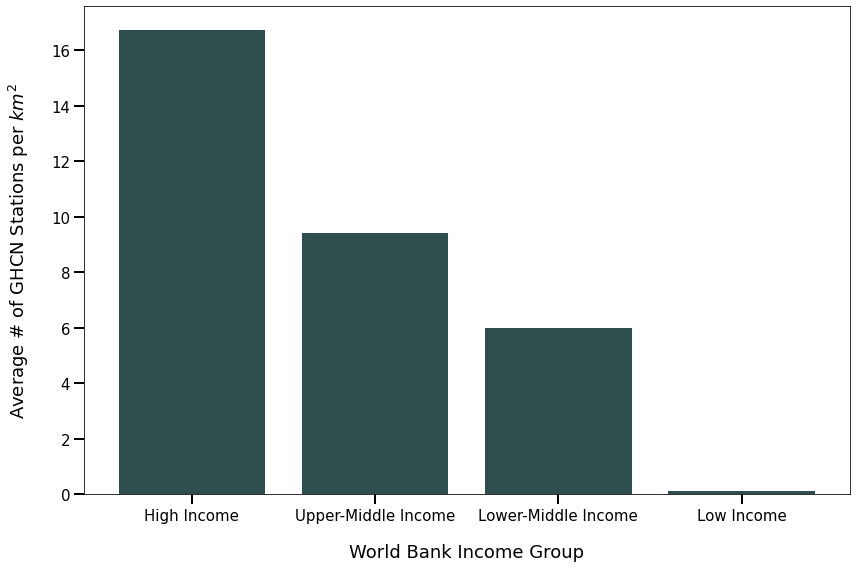

In [82]:
# Sort by 'mean_station_density' in descending order (high to low)
mean_station_density_sorted = mean_station_density_v2.sort_values(by='station_density_mean', ascending=False)


plt.figure(figsize=[12, 8])
plt.bar(mean_station_density_sorted['Income_Category_'], (mean_station_density_sorted['station_density_mean']), color = 'darkslategrey')

plt.xlabel('World Bank Income Group', fontsize=18, labelpad=20)
plt.ylabel('Average # of GHCN Stations per $km^2$', fontsize=18, labelpad=20)

plt.tick_params('both', length=10, width=2, which='major')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(False)
plt.tight_layout()
plt.savefig(f"{export_dir}/datapovertybarplot.png", dpi=400)

plt.show()

